In [505]:
import os
from os import path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
import random
import math
import pickle
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

### Подготовка данных

В файле сводки (*_gen) есть следующие обязательные поля: генготип, возраст, пол; и ряд необязательных.

Порядковый номер строки в файле сводки - это номер канала записи, он соответствует номеру столбца в файле данных

Генотипы бывают следующими:
1. a - гомозигота (два битых гена)
2. h - гемизигота (один битый ген)
3. w - дикийТип (оба гена здоровых)
4. d - больной (гомо- или гемизигота, но не дикий тип)
5. NA - генотип не определён

Пол может быть:
1. f - самка
2. m - самец
 
Дробная цифра - это возраст в месяцах
 
Записи вида 47s8F - это индивидуальные идентификаторы мышей, есть не везде.

In [506]:
def get_dict_mouse_gen(gen_string : str, numb_mouse : int) -> dict:
    start = 0
    gen_string = gen_string.rstrip('\n')
    gen_string = gen_string.replace(',', '.')

    mouse_params = gen_string.split(' ')
    if len(mouse_params) < 3:
        mouse_params = gen_string.split('\t')
        start += 1
        
    return {
        'mouse_id': None,
        'experiment_name': None,
        'numb_mouse': numb_mouse,
        'gene': mouse_params[start],
        'age': float(mouse_params[start+1]) if mouse_params[start+1] != 'NA' else 0,
        'sex': mouse_params[start+2],
        'ts': None
    }

In [507]:
def get_list_mice_without_ts(dirname : str, experiment_name : str, experiment_index : int) -> list:
    mice_list = []
    file_path = path.join(os.sep, dirname, experiment_name + '_gen.txt')
    with open(file_path, 'r') as f:
        for indx, line in enumerate(f):
            if line.strip():
                mouse = get_dict_mouse_gen(line, indx)
                mouse['experiment_name'] = experiment_name
                mouse['mouse_id'] = experiment_index * 16 + indx
                mice_list.append(mouse)
            else:
                break
    return mice_list

In [508]:
def get_ts_from_file(dirname : str, experiment_numbers: list) -> dict:
    result = {}
    for i in experiment_numbers:
        exper_name = 'FAD{:02d}'.format(i)
        df = pd.read_csv(path.join(os.sep, dirname, exper_name + '_lite.txt'), header=None, delim_whitespace=True)
        result[exper_name] = df.to_dict(orient='list')
    
    return result 


In [509]:
def fill_ts_to_mice(mice_list: list, ts_dict: dict) -> list:
    for mouse in mice_list:
        mouse['ts'] = ts_dict[mouse['experiment_name']][mouse['numb_mouse']]
    return mice_list

In [510]:
experiment_numbers = [1,2,3,4,5,6,7,9,15,17]

dirname = os.path.abspath(os.curdir) + r'\data\FAD_SLA'

# Заполняем список мышей
mice_list = []
for indx, numb in enumerate(experiment_numbers):
    mice_list.extend(get_list_mice_without_ts(
        dirname,
        'FAD{:02d}'.format(numb),
        indx
        )
    )
# Получаем временные ряды для каждой мыши и записываем соответсвующей мыши
ts_dict = get_ts_from_file(dirname, experiment_numbers)
mice_list = fill_ts_to_mice(mice_list, ts_dict)

Из сформированного списка словарей формируем датафрейм 

In [511]:
def replace_with_dict(df, column_name : str):
    """
    Функция заменяет все имена на числовые значения и выводит
    словарь, по которому производился маппинг
    """
    unique_values = df[column_name].unique()
    value_dict = {value: idx for idx, value in enumerate(unique_values)}
    df[column_name] = df[column_name].replace(value_dict)
    return df, value_dict

In [512]:
df = pd.DataFrame(mice_list)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mouse_id         154 non-null    int64  
 1   experiment_name  154 non-null    object 
 2   numb_mouse       154 non-null    int64  
 3   gene             154 non-null    object 
 4   age              154 non-null    float64
 5   sex              154 non-null    object 
 6   ts               154 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 8.5+ KB


Приводим все строковые значения к числовым и выводим словари, по которым осуществлялся маппинг

In [513]:
df, d_experiment = replace_with_dict(df, 'experiment_name')
df, d_gene = replace_with_dict(df, 'gene')
df, d_sex  = replace_with_dict(df, 'sex')

print(d_experiment)
print(d_gene)
print(d_sex)

{'FAD01': 0, 'FAD02': 1, 'FAD03': 2, 'FAD04': 3, 'FAD05': 4, 'FAD06': 5, 'FAD07': 6, 'FAD09': 7, 'FAD15': 8, 'FAD17': 9}
{'NA': 0, 'w': 1, 'd': 2, 'wt': 3, 'h': 4, 'a': 5}
{'NA': 0, 'f': 1, 'm': 2}


In [514]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mouse_id         154 non-null    int64  
 1   experiment_name  154 non-null    int64  
 2   numb_mouse       154 non-null    int64  
 3   gene             154 non-null    int64  
 4   age              154 non-null    float64
 5   sex              154 non-null    int64  
 6   ts               154 non-null    object 
dtypes: float64(1), int64(5), object(1)
memory usage: 8.5+ KB


Удаляем всех мышей, с неопределенным геном

In [515]:
df = df[df['gene'] != d_gene['NA']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138 entries, 1 to 153
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mouse_id         138 non-null    int64  
 1   experiment_name  138 non-null    int64  
 2   numb_mouse       138 non-null    int64  
 3   gene             138 non-null    int64  
 4   age              138 non-null    float64
 5   sex              138 non-null    int64  
 6   ts               138 non-null    object 
dtypes: float64(1), int64(5), object(1)
memory usage: 8.6+ KB


Графики по различной группировке уникальных значений и кол-ву мышей на каждом из графиков (опционально)

In [516]:
def plot_experiment_subplots(df, group_name, count_mouse = None, fig_size=(30, 20)):

    unique_group = df[group_name].unique()
    grid_shape = (len(unique_group), 1)
    
    fig, ax = plt.subplots(*grid_shape, figsize=fig_size)
    fig.tight_layout(pad=5.0)
    
    for i, group in enumerate(unique_group):
        group_data = df[df[group_name] == group]
        
        if count_mouse and len(group_data) > count_mouse:
            group_data = group_data.sample(count_mouse)
        
        for j, row in group_data.iterrows():
            ax[i].plot(row['ts'], label=f"{row['numb_mouse']}:{row['gene']}")
        
        # Добавляем заголовок и легенду к текущему подграфику
        ax[i].set_title(f'{group_name}: {group}')
        ax[i].legend()
        ax[i].set_xlabel('Time')
        ax[i].set_ylabel('ts')
    
    # Показываем график
    plt.show()


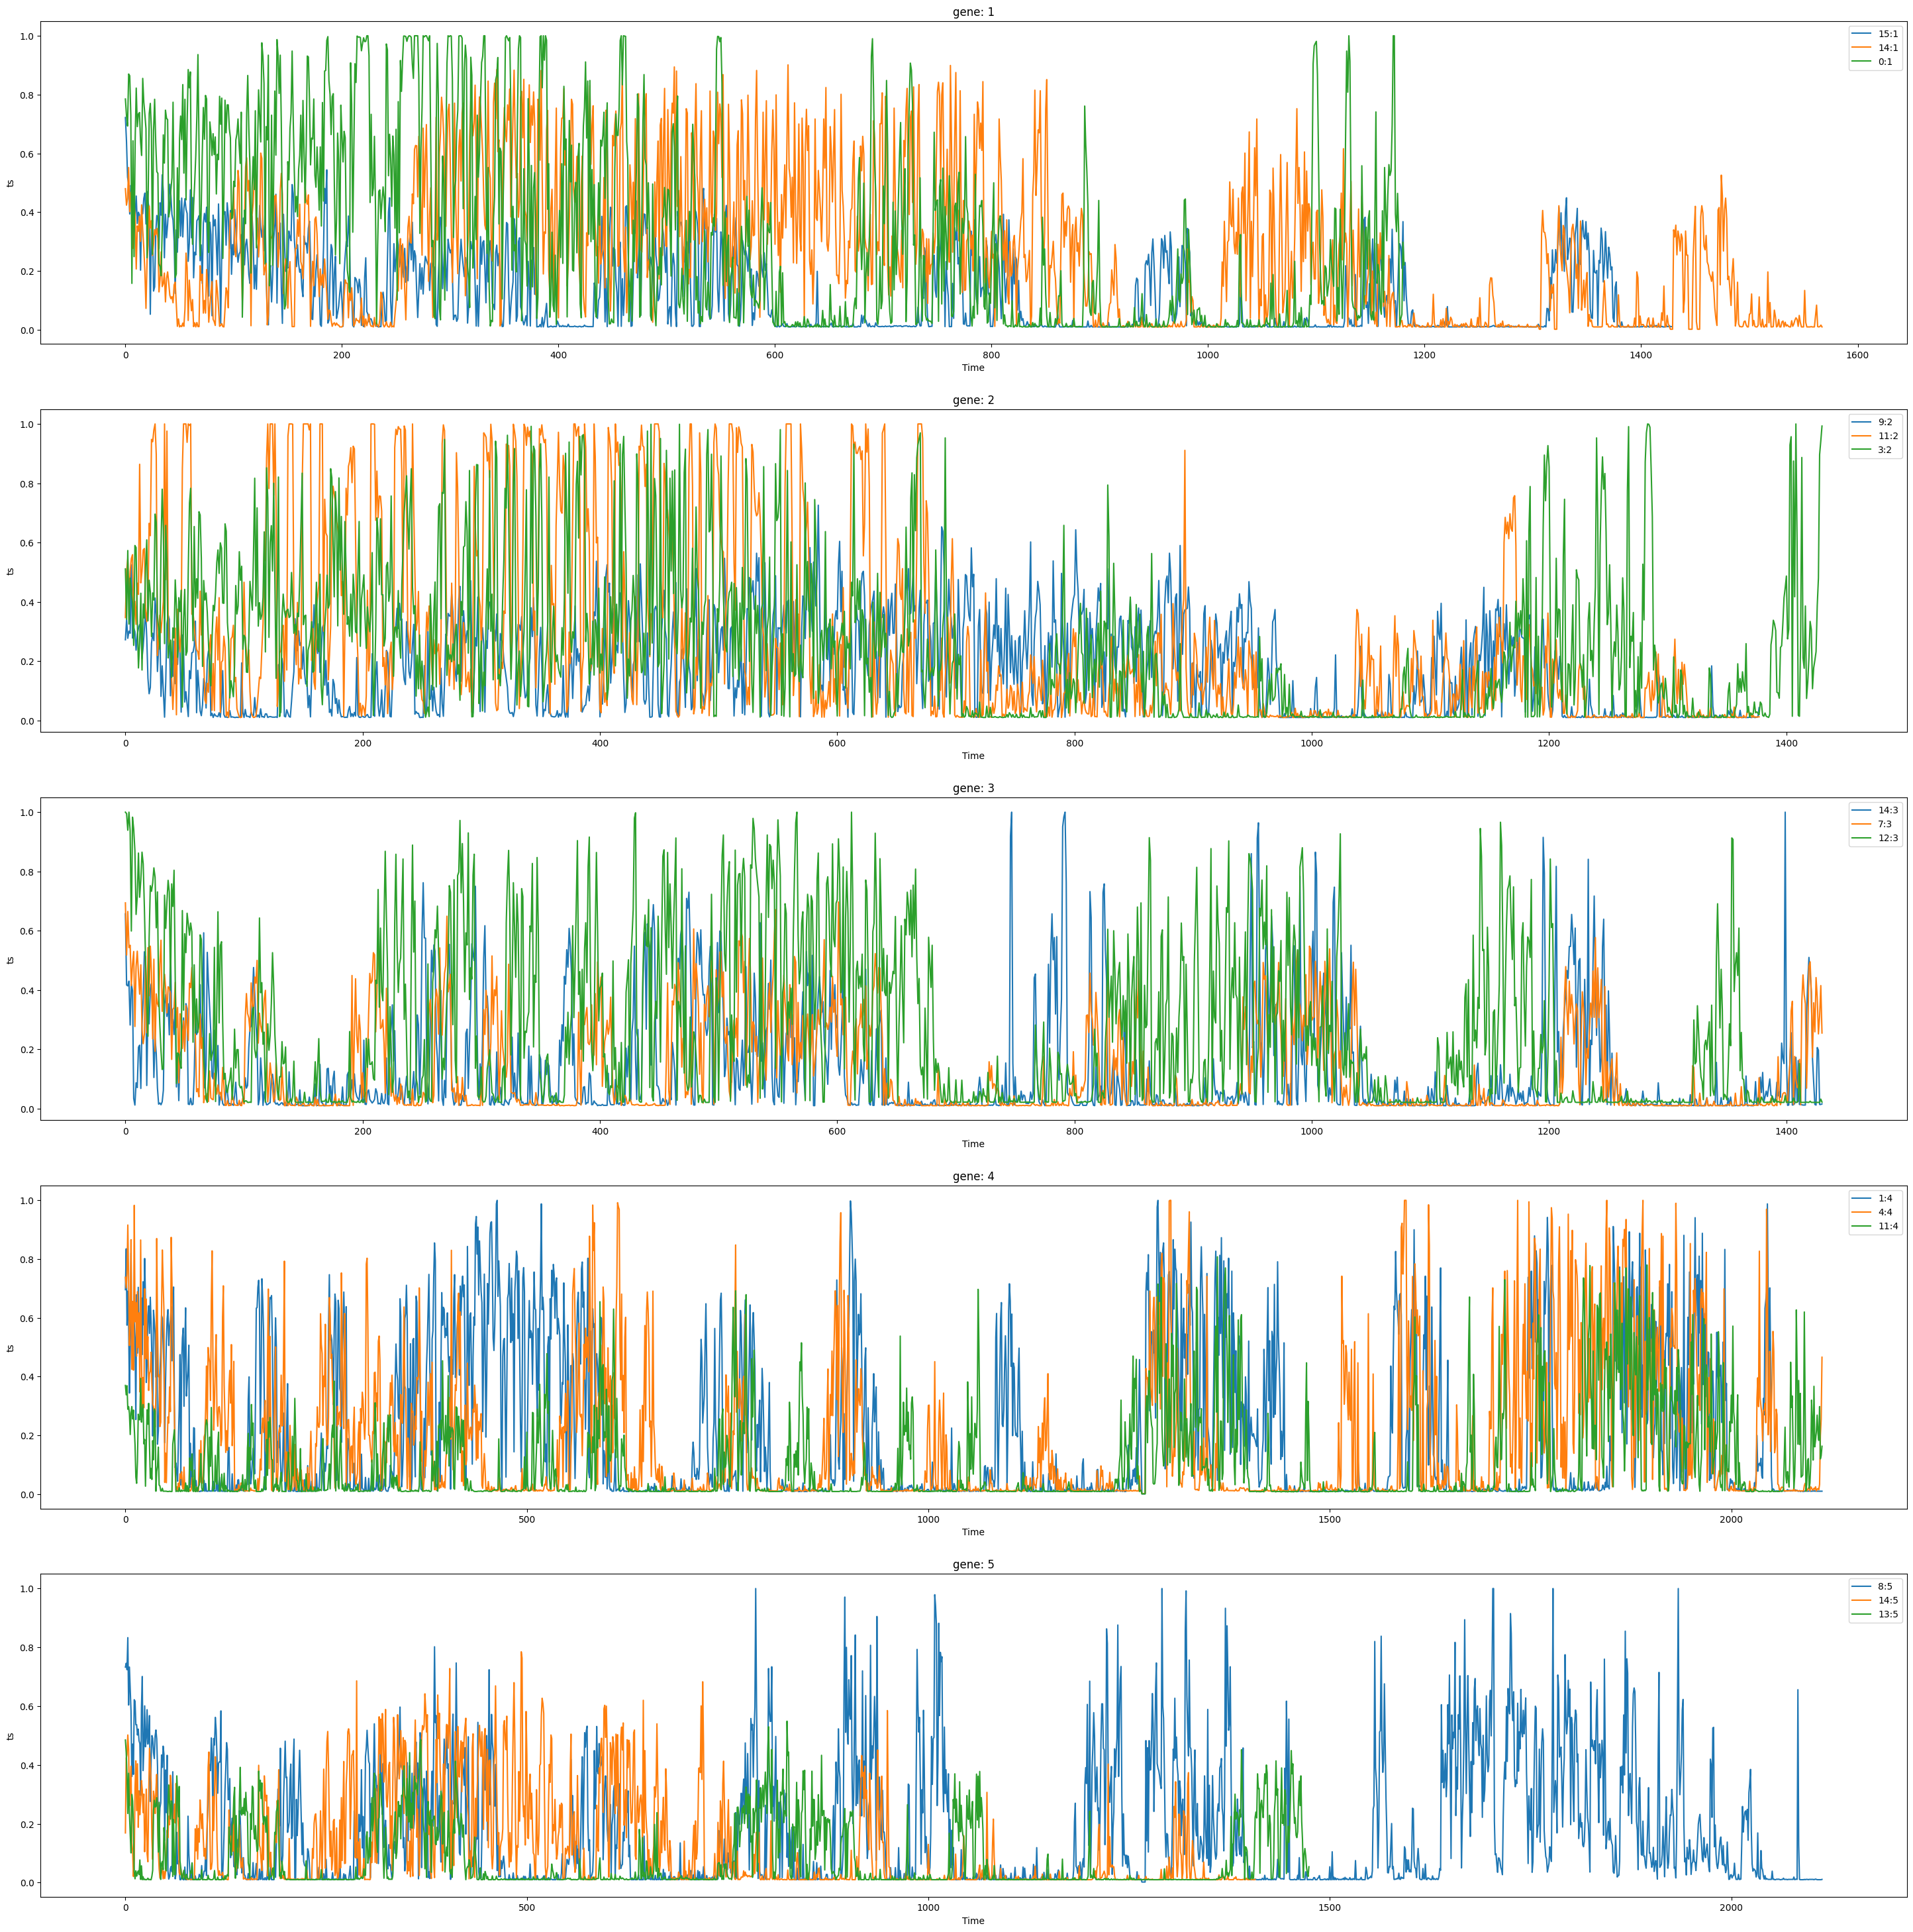

In [517]:
plot_experiment_subplots(df, 'gene', 3, (30, 30))

Также сделаем заготовку, чтобы работать с бинарной классификацией. Создадим целефой признак - <b>is_sick</b>.
<br>Мышей будем делить на больных (те, у кого <b>gene</b> = d) - 1,
<br>и здоровых (те, у кого <b>gene</b> <> d) - 0.

In [518]:
df['is_sick'] = df['gene'].apply(lambda x: 1 if x == d_gene['d'] else 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138 entries, 1 to 153
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mouse_id         138 non-null    int64  
 1   experiment_name  138 non-null    int64  
 2   numb_mouse       138 non-null    int64  
 3   gene             138 non-null    int64  
 4   age              138 non-null    float64
 5   sex              138 non-null    int64  
 6   ts               138 non-null    object 
 7   is_sick          138 non-null    int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 9.7+ KB


Посмотрим на распределение больных и здоровых мышей в наборе данных:

In [519]:
sick_perc = len(df[df['is_sick'] == 1]) / len(df)*100
healthy_perc = len(df[df['is_sick'] == 0]) / len(df)*100
print(f'Процент здоровых мышей: {healthy_perc:.2f}%')
print(f'Процент больных мышей: {sick_perc:.2f}%')

Процент здоровых мышей: 89.86%
Процент больных мышей: 10.14%


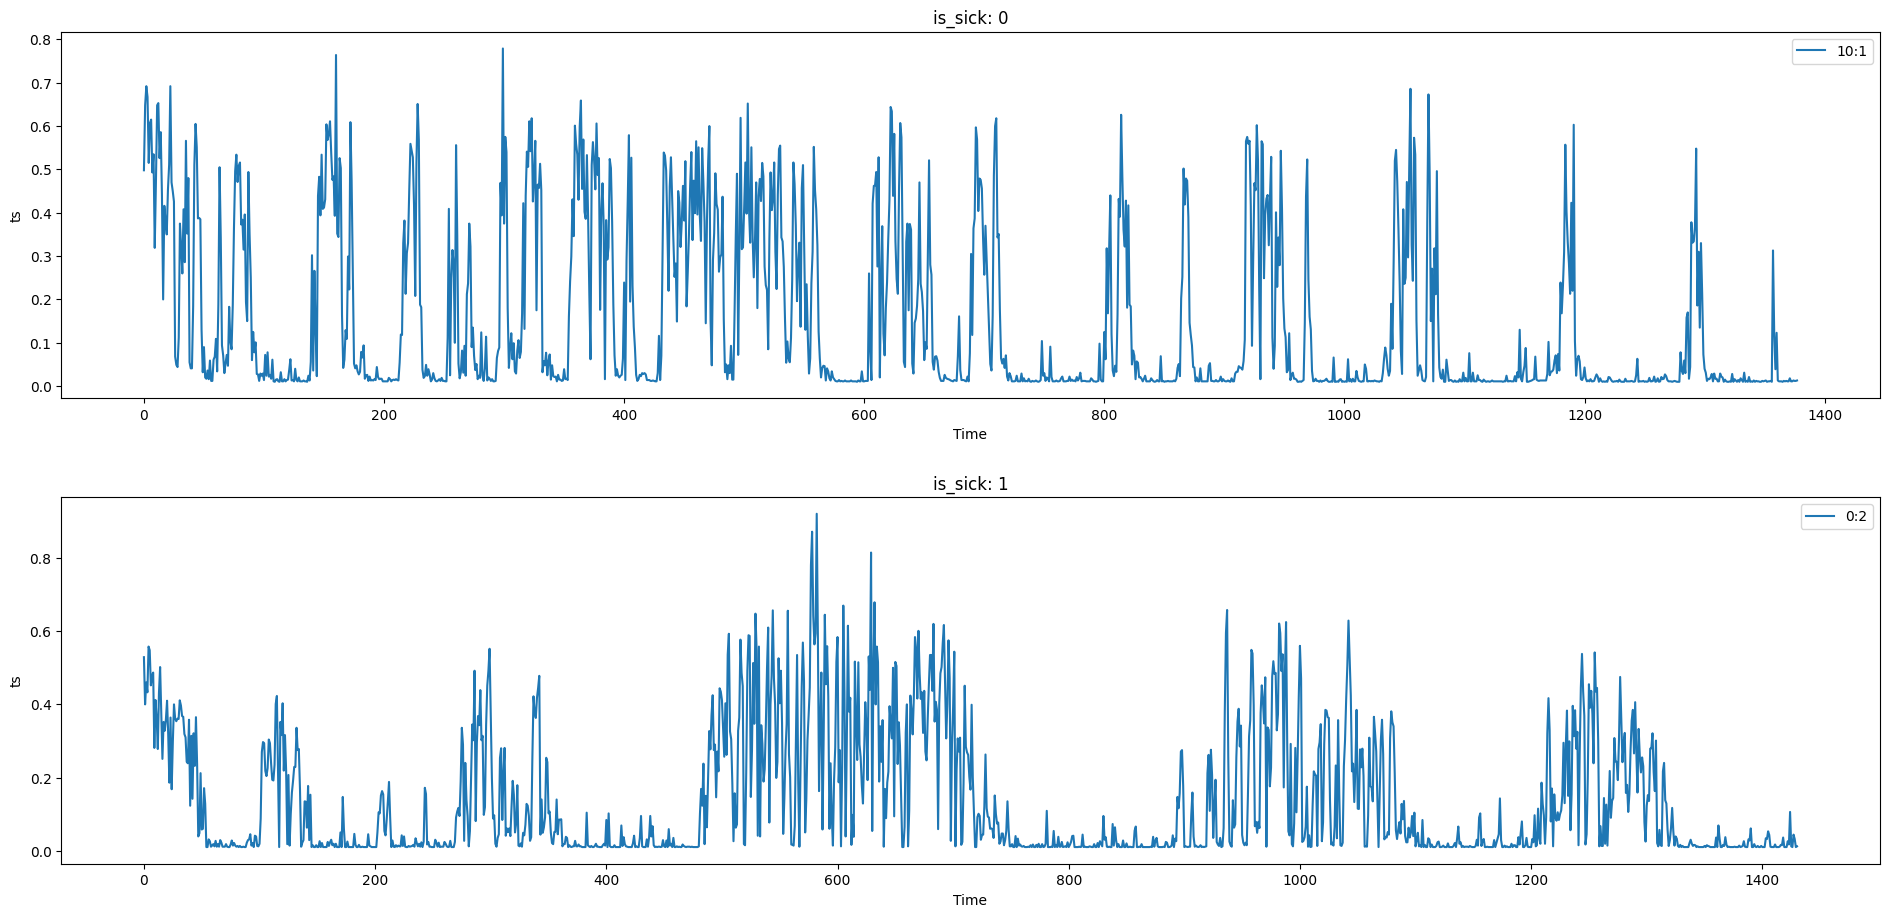

In [520]:
plot_experiment_subplots(df, 'is_sick', 1, (20, 10))

Посмотрим на распределение мышей по генам

In [521]:
total = len(df)
for key, value in d_gene.items():
    count = len(df[df['gene'] == value])
    print(f'Процент мышей с геном {key}: {count/total*100:.2f}%')

Процент мышей с геном NA: 0.00%
Процент мышей с геном w: 45.65%
Процент мышей с геном d: 10.14%
Процент мышей с геном wt: 4.35%
Процент мышей с геном h: 26.81%
Процент мышей с геном a: 13.04%


#### Шейплеты

##### Функции для создания шейплетов

Нормализация ряда

In [522]:
def norm(R):
    m = np.mean(R) # Среднее по ряду
    s = np.std(R) # Стандатроне отклонение
    if s > 0.00001: 
        res = (R-m)/s # Приводим к нормальной форме
    else:
        res = R - m
    return res

Определение расстояния между рядами

In [523]:
def dist(R,L):
    R = norm(R) # Нормальные формы обоих рядов
    L = norm(L)
    S = R - L # Вычисляем разницу между соответствующими элементами рядов
    S = S*S # Возводим в квадрат
    res = np.sum(S) # Получаем сумму квадратов разности между рядами
    return res

Извлечение подпоследовательности

In [524]:
def extract_subsequnces(T,lenght):
    res = []
    for i in range(len(T)-lenght+1):
        res.append(T[i:i+lenght]) # Создаем список из всех возможных подп. длины lenght
    return res

Расстояние между временными рядами

In [525]:
def dist_series(R,T):
    Subs = extract_subsequnces(T,len(R)) # Берем все подпоследовательности нужной длины
    distances = np.zeros(len(Subs)) # Задаем пустой массив для расстояний 
    for i,j in enumerate(Subs):
        distances[i] = dist(R,j) # Заполняем массив расстояниями
    res = np.min(distances) # Берем минимальное расстояние 
    return res

Вычисление энтропии ряда по формуле Шеннона

In [526]:
def entropy(T):
    n = len(T)
    if n != 0:
        ones = np.sum(T)
        zeros = n - ones
        res = 0
        if zeros != 0:
            res += -zeros/n*np.log(zeros/n)
        if ones != 0:
            res += -ones/n*np.log(ones/n)
    else:
        res = 0
    return res

Вычисляем качество

In [527]:
def calc_quality(Ds,lables):
    temp = list(zip(Ds,lables)) # Объединяем ряд с лейблами
    temp = sorted(temp,key=lambda x: x[0]) # Сортируем по ряду
    labels = np.array([i[1] for i in temp]) # Возвращаем отсотритрованный ряд лейблов 
    igs = np.zeros(len(labels)) # массив оценок IG
    base = entropy(labels) 
    n = len(labels)
    for i in range(len(temp)):
        igs[i] = base - (i/n*entropy(labels[:i]) + (n-i)/n*entropy(labels[i:])) # Вычисляем количество информации
    res = np.max(igs)
    return res

Удаление одинаковых шейплетов

In [528]:
def remove_similar(shapelets):
    flags = [True]*len(shapelets) # создаем спсиок флажков
    for i in range(len(shapelets)): # Проходим по всем парам шейплетов
        for j in range(i+1,len(shapelets)):
            if dist(shapelets[i][0],shapelets[j][0]) < 0.00001:  # Если они совпадают с указанной точностью
                flags[i] = False  # Меняем флажок на False
                break
    for i in range(len(flags)-1,-1,-1):
        if not flags[i]:
            shapelets.pop(i) # А затем удаляем повторы
    return shapelets

Добавление шейплета

In [529]:
def add_if_new(shapelets,shap):
    flag = True
    for j in range(len(shapelets)):
            if dist(shap[0],shapelets[j][0]) < 0.0000001: # Проверяем шейплет на наличие копии
                flag = False
                break
    if flag:
         shapelets.append(shap) # Добавляем если копии нет
    return flag

##### Подготовка данных к анализу

Т.к. не хватает вычислительных мощностей, то заранее сформируем обучающую выборку с
<br>равным количеством больных и условно здоровых мышей.
<br>Также уменьшим выборку до 18 часов и снизим дискретность данных в 10 раз, усреднив значение показателей с датчика

Образаем и усредняем временные ряды:

In [530]:
def trim_average_ts(ts):
    ts = ts[:1080] 
    average_ts = [sum(ts[i:i+5]) / 5 for i in range(0, len(ts), 5)]
    return average_ts

df_sh = df.copy()
df_sh['ts'] = df_sh['ts'].apply(trim_average_ts)

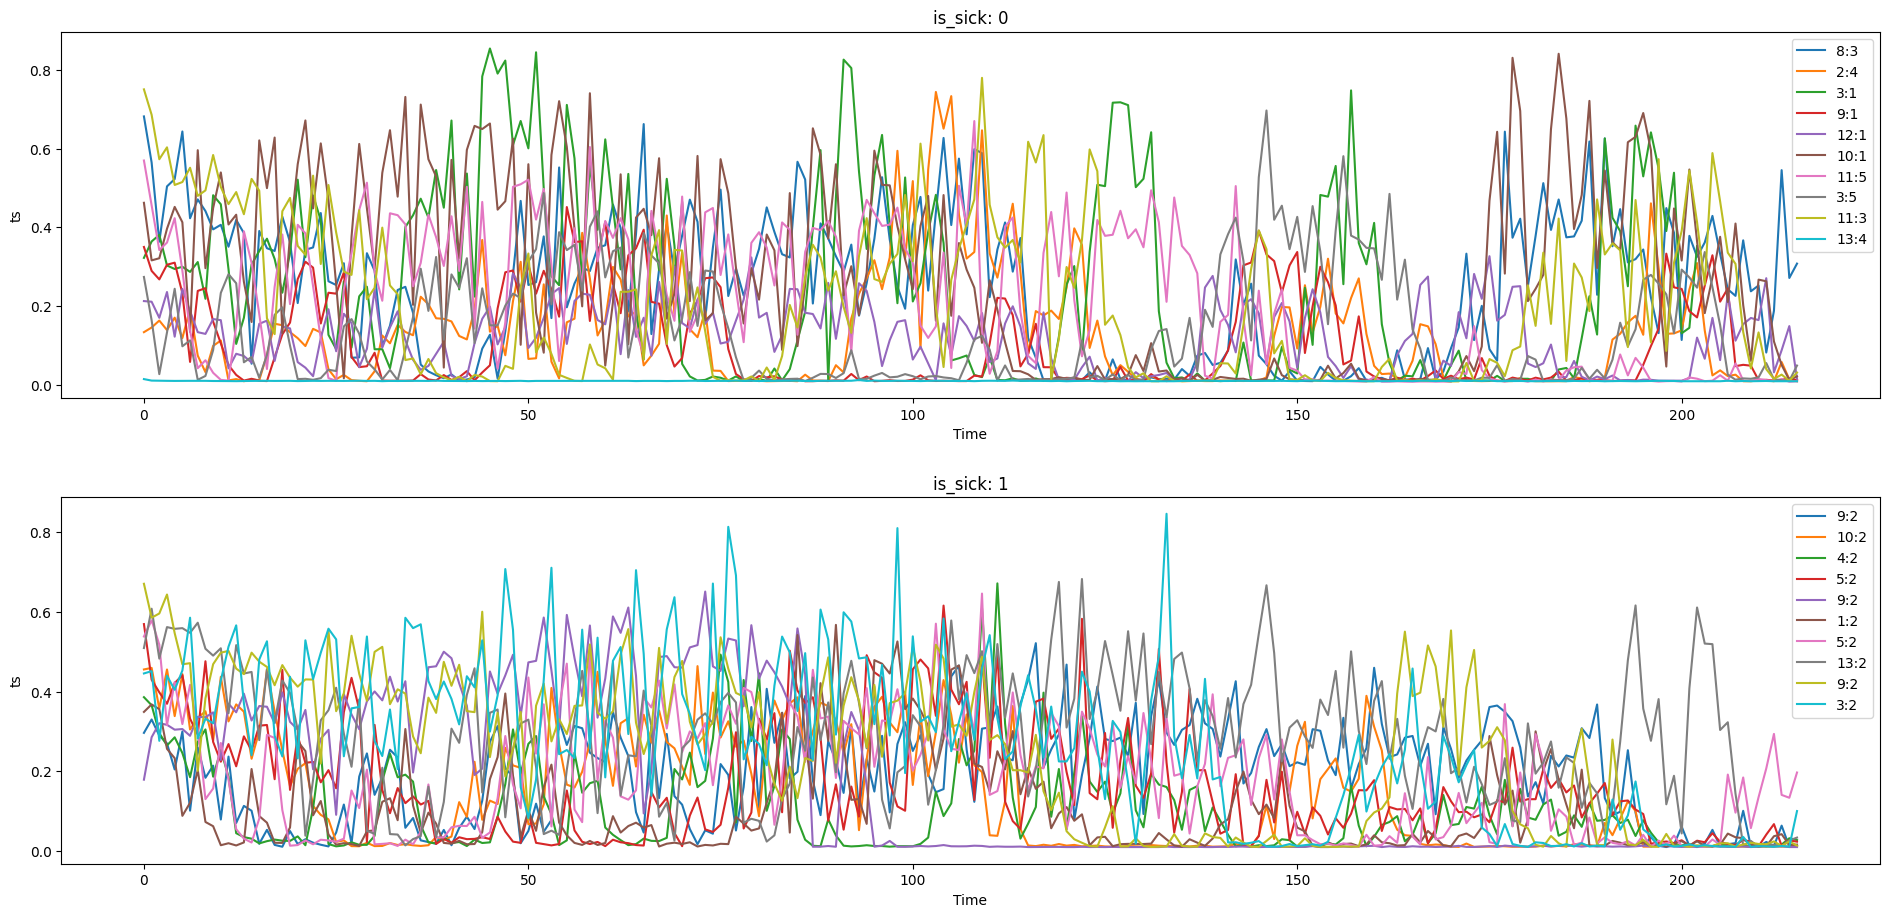

In [531]:
plot_experiment_subplots(df_sh, 'is_sick', 10, (20, 10))

Формируем учебный и тестовый наборы данных:

Распределяем больных мышей по наборам данных:

In [532]:
train_serieses = []
train_lables_gene = []
train_lables_bin = []

test_serieses = []
test_lables_gene = []
test_lables_bin = []

count_sick_mice = len(df_sh[df_sh['is_sick'] == 1])
count_sick_train = math.floor(count_sick_mice * 0.8)    # 80% больных мышей берем в обучающую выборку
count_sick_test = math.ceil(count_sick_mice * 0.2)      # 20% больных мышей берем в тестовую выборку

df_sick_mice = df_sh[df_sh['is_sick'] == 1].copy()

# Формируем учебный датасет с больными мышами
mice_train_sample = df_sick_mice.sample(n=count_sick_train)
train_serieses = mice_train_sample['ts'].to_list()
train_lables_gene = [d_gene['d']] * count_sick_train
train_lables_bin = [1] * count_sick_train

# Формируем тестовый датасет с больными мышами
mice_test_sample = df_sick_mice.drop(mice_train_sample.index)
test_serieses = mice_test_sample['ts'].to_list()
test_lables_gene = [d_gene['d']] * count_sick_test
test_lables_bin = [1] * count_sick_test

Распределяем остальных мышей по наборам данных:

In [533]:
df_no_sick = df_sh[df_sh['is_sick'] != 1]

# Добавляем к учебному датасету такое же количество остальных мышей
mice_train_sample = df_no_sick.sample(n=count_sick_train)
train_serieses = mice_train_sample['ts'].to_list()
for index, row in mice_train_sample.iterrows():
    train_lables_gene.append(row['gene'])
    train_lables_bin.append(0)

# Добавляем к датасету оставшихся мышей
mice_test_sample = df_no_sick.drop(mice_train_sample.index)
test_serieses = mice_test_sample['ts'].to_list()
for index, row in mice_test_sample.iterrows():
    test_lables_gene.append(row['gene'])
    test_lables_bin.append(0)

In [534]:
train_dataset = list(zip(train_serieses, train_lables_gene, train_lables_bin))
test_dataset = list(zip(test_serieses, test_lables_gene, test_lables_bin))

random.seed(121)
random.shuffle(train_dataset)
random.shuffle(test_dataset)

train_serieses = [i[0] for i in train_dataset]
train_lables_gene = [i[1] for i in train_dataset]
train_lables_bin = [i[2] for i in train_dataset]

test_serieses = [i[0] for i in test_dataset]
test_lables_gene = [i[1] for i in test_dataset]
test_lables_bin = [i[2] for i in test_dataset]

In [535]:
# #Ограничения длины шапилетов
# min_len = 10
# max_len = 12

# #Кол-во шейплетов, которое достается из каждого обучающего ряда
# p = 7

# # С какими лейблами работаем
# lables = train_lables_gene

# #найденные шейплеты по длинам
# rShapeles = {}
# for i in range(min_len,max_len+1):
#     rShapeles[i] = []

# for d,i in enumerate(train_serieses):
#     print(f"{d+1}/{len(train_serieses)}")
#     shapelets = []
#     #Достаем все шейплеты из ряда и оцениваем их
#     for j in range(min_len,max_len+1):
#         sh_same_lenght = []
#         W = extract_subsequnces(i,j)
#         for k in W:
#             Ds = np.zeros(len(train_serieses))
#             for z,f in enumerate(train_serieses):
#                 Ds[z] = dist_series(k,f)
#             quality = calc_quality(Ds,lables)
#             sh_same_lenght.append((k,quality))
#         #Удаляем потворы
#         sh_same_lenght = remove_similar(sh_same_lenght)
#         shapelets.extend(sh_same_lenght)
#     #Сортируем шейплеты по качеству и добавляем только p лучших (если они уже не добавлены из прошлых рядов)
#     shapelets = sorted(shapelets,key=lambda x: x[1],reverse=True)
#     s = 0
#     j = 0
#     while j < len(shapelets) and s < p:
#         if add_if_new(rShapeles[len(shapelets[j][0])],shapelets[j]):
#             s += 1
#         j += 1
#     # Сохраняем найденный шейплеты в бинарный файл
#     with open(f'rShapeles_{d+1}.pkl', 'wb') as f:
#         pickle.dump(rShapeles, f)

In [536]:
with open('rShapeles_5minuts_10min_12max.pkl', 'rb') as f:
    rShapeles = pickle.load(f)

In [537]:
SH = []
qualities = []

for i in rShapeles.keys():
    for j in rShapeles[i]:
        SH.append(j[0]) # Объединяем все шейплеты в единый список
        qualities.append(j[1]) # Как и их качество

Вычисляем рассотояние от шейплетов до временного ряда:

In [538]:
def constract_features_vector(T,shapelets):
    D = np.zeros(len(shapelets))
    for i in range(len(shapelets)):
        D[i] = dist_series(shapelets[i],T)
    return D

In [539]:
# train_features = [constract_features_vector(i,SH) for i in train_serieses]
# test_features = [constract_features_vector(i,SH) for i in test_serieses]

In [540]:
# clf = RandomForestClassifier(1000)
# clf.fit(train_features,train_lables_bin)

In [541]:
# print("Итоги обучения")
# print(f"Train accuracy={clf.score(train_features,train_lables_bin)}")
# print(f"test accuracy={clf.score(test_features,test_lables_bin)}")

#### Спектограммы

##### Подготовка спектров

Т.к. анализ шейплетов не привел к результатам (из-за ограничения вычислительных ресурсов),<br>было принято решение обучить нейронную сеть анализировать спектограммы

In [542]:
df.info()
d_gene

<class 'pandas.core.frame.DataFrame'>
Index: 138 entries, 1 to 153
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mouse_id         138 non-null    int64  
 1   experiment_name  138 non-null    int64  
 2   numb_mouse       138 non-null    int64  
 3   gene             138 non-null    int64  
 4   age              138 non-null    float64
 5   sex              138 non-null    int64  
 6   ts               138 non-null    object 
 7   is_sick          138 non-null    int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 9.7+ KB


{'NA': 0, 'w': 1, 'd': 2, 'wt': 3, 'h': 4, 'a': 5}

Разобъем временные ряды на отрезки по 60 минут и преобразуем в спектрограммы:

In [543]:
from scipy import signal

In [578]:
SAMPLE_RATE = 1
PERIOD = 60

def convert_ts_to_spectrogram(ts):
    ts_np = np.array(ts)
    frequency_array, timeline, sprgram = signal.spectrogram(ts_np, SAMPLE_RATE, nperseg=14)
    spectrogram = {
        'frequency_array' : frequency_array,
        'timeline' : timeline,
        'spectrogram' : np.log(sprgram)
    }

    return spectrogram

In [579]:
def divide_ts_into_time_intervals(ts, period):
    ts = ts[0:1200]
    res = {}
    for hour, start in enumerate(range(0, 1200, period)):
        res[hour] = convert_ts_to_spectrogram(ts[start : start + period])
    return res

In [580]:
df_by_hour = df.copy()
df_by_hour['time_intervals'] = df_by_hour['ts'].apply(divide_ts_into_time_intervals, period=PERIOD)

C:\Users\danon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 14 is greater than input length  = 0, using nperseg = 0
  warnings.warn('nperseg = {0:d} is greater than input length '


Напишем функцию, которая будет выводить спектрограммы за сутки:

In [581]:
def display_mouse_spectrograms(mouse, rows, columns, figsize=(20, 10)):
    fig, ax = plt.subplots(rows, columns, figsize=figsize)
    spectrograms = mouse.get('time_intervals')
    number = 0
    hours = PERIOD / 60
    if spectrograms:
        for row in range(rows):
            for col in range(columns):
                sprgram = spectrograms.get(number)
                if sprgram:
                    tline = sprgram['timeline']
                    frq = sprgram['frequency_array']
                    sptg = sprgram['spectrogram']
                    ax[row][col].pcolormesh(tline, frq, sptg, shading='auto')
                ax[row][col].set_title(f'Время суток: {hours*(number):.0f}:00 - {hours*(number+1):.0f}:00')
                number += 1
    state = 'здоровой' if mouse['is_sick']==0 else 'больной'
    fig.suptitle(f'Спектрограммы для {state} мыши')


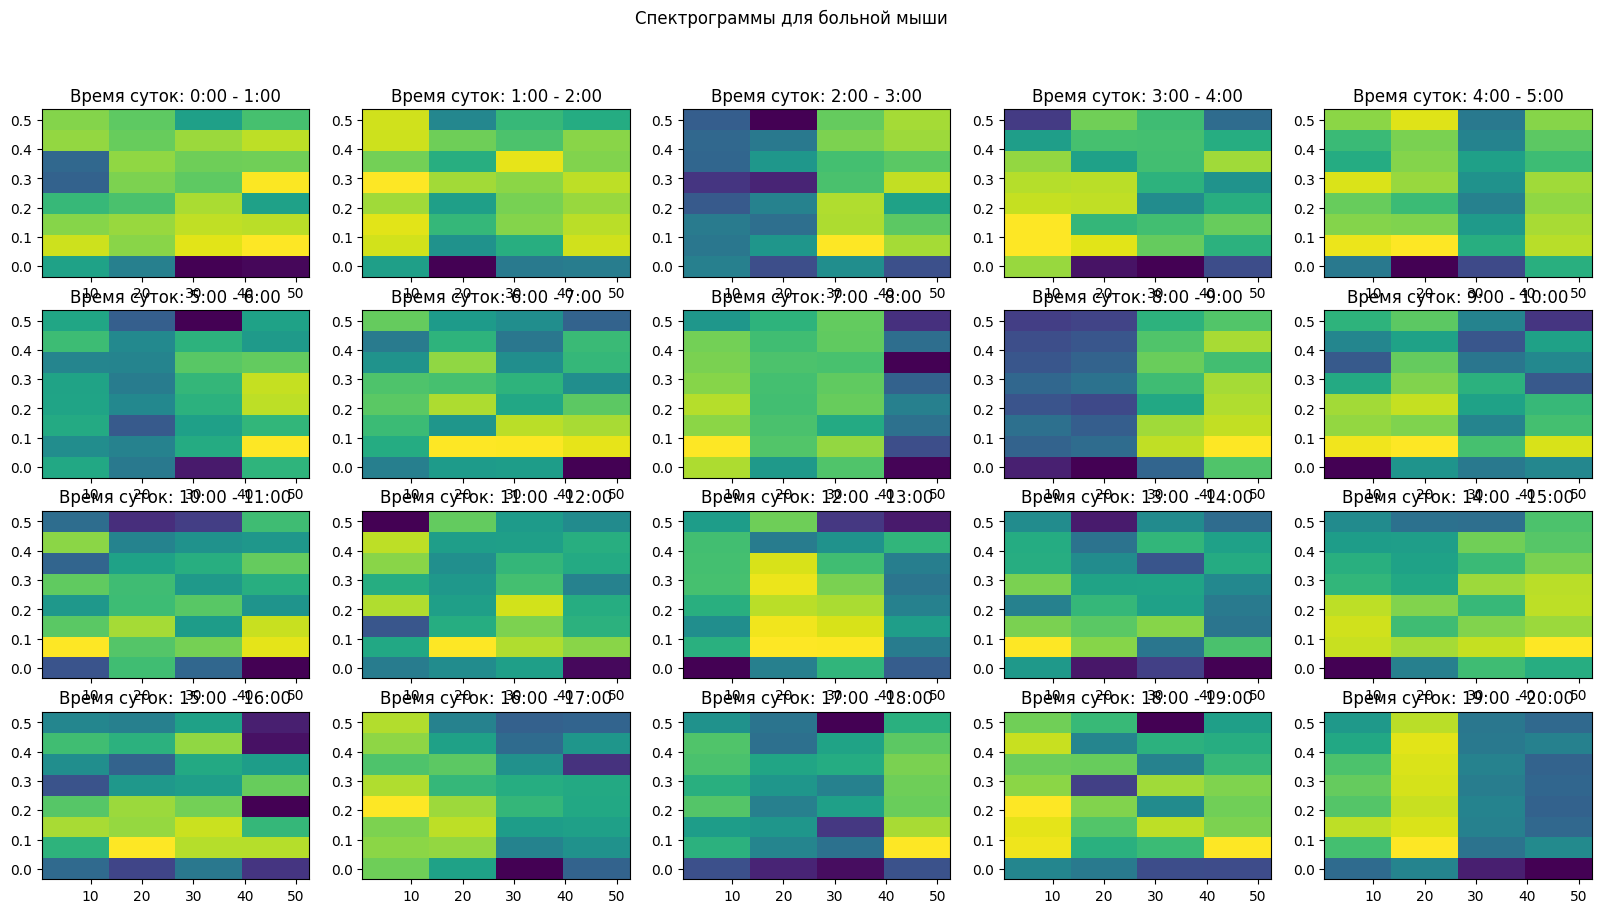

In [582]:
display_mouse_spectrograms(df_by_hour.iloc[1], 4, 5, (20, 10))

##### Разбиение данных и классификация

Формируем учебный и тестовый наборы данных:

Распределяем больных мышей по наборам данных:

In [583]:
train_serieses = []
train_lables_gene = []
train_lables_bin = []

test_serieses = []
test_lables_gene = []
test_lables_bin = []

count_sick_mice = len(df_by_hour[df_by_hour['is_sick'] == 1])
count_sick_train = math.floor(count_sick_mice * 0.8)    # 80% больных мышей берем в обучающую выборку
count_sick_test = math.ceil(count_sick_mice * 0.2)      # 20% больных мышей берем в тестовую выборку

df_sick_mice = df_by_hour[df_by_hour['is_sick'] == 1].copy()

# Формируем учебный датасет с больными мышами
mice_train_sample = df_sick_mice.sample(n=count_sick_train)
for index, row in mice_train_sample.iterrows():
    spectrograms = row['time_intervals']
    for key, spgrams in spectrograms.items():
        spgram_to_list = list(map(lambda arr: arr.tolist(), spgrams['spectrogram']))
        train_serieses.extend(spgram_to_list)
        train_lables_gene.extend([d_gene['d']] * len(spgram_to_list))
        train_lables_bin.extend([1] * len(spgram_to_list))

# Формируем тестовый датасет с больными мышами
mice_test_sample = df_sick_mice.drop(mice_train_sample.index)
for index, row in mice_test_sample.iterrows():
    spectrograms = row['time_intervals']
    for key, spgrams in spectrograms.items():
        spgram_to_list = list(map(lambda arr: arr.tolist(), spgrams['spectrogram']))
        test_serieses.extend(spgram_to_list)
        test_lables_gene.extend([d_gene['d']] * len(spgram_to_list))
        test_lables_bin.extend([1] * len(spgram_to_list))

Распределяем остальных мышей по наборам данных:

In [584]:
df_no_sick = df_by_hour[df_by_hour['is_sick'] != 1]

# Добавляем к учебному датасету такое же количество остальных мышей
mice_train_sample = df_no_sick.sample(n=count_sick_train * 2)
for index, row in mice_train_sample.iterrows():
    spectrograms = row['time_intervals']
    for key, spgrams in spectrograms.items():
        spgram_to_list = list(map(lambda arr: arr.tolist(), spgrams['spectrogram']))
        train_serieses.extend(spgram_to_list)
        train_lables_gene.extend([d_gene['d']] * len(spgram_to_list))
        train_lables_bin.extend([1] * len(spgram_to_list))

# Добавляем к датасету оставшихся мышей
mice_test_sample = df_no_sick.drop(mice_train_sample.index)
for index, row in mice_test_sample.iterrows():
    spectrograms = row['time_intervals']
    for key, spgrams in spectrograms.items():
        spgram_to_list = list(map(lambda arr: arr.tolist(), spgrams['spectrogram']))
        test_serieses.extend(spgram_to_list)
        test_lables_gene.extend([d_gene['d']] * len(spgram_to_list))
        test_lables_bin.extend([1] * len(spgram_to_list))

Фильтруем от несоразмерных / неккоректных данных:

In [585]:
train_dataset = list(zip(train_serieses, train_lables_gene, train_lables_bin))
test_dataset = list(zip(test_serieses, test_lables_gene, test_lables_bin))

# Фильтруем датасеты от значений, не вписывающихся в общую размерность
all_lengths = [len(item[0]) for item in train_dataset + test_dataset]
most_common_length = Counter(all_lengths).most_common(1)[0][0]
train_dataset = [item for item in train_dataset if len(item[0]) == most_common_length]
test_dataset = [item for item in test_dataset if len(item[0]) == most_common_length]

train_dataset = [data_row for data_row in train_dataset if not any(np.isinf(value) for value in data_row[0])]
test_dataset = [data_row for data_row in test_dataset if not any(np.isinf(value) for value in data_row[0])]

Перемешиваем данные:

In [586]:
random.seed(121)
random.shuffle(train_dataset)
random.shuffle(test_dataset)

train_serieses = [list(i[0]) for i in train_dataset]
train_lables_gene = [i[1] for i in train_dataset]
train_lables_bin = [i[2] for i in train_dataset]

test_serieses = [i[0] for i in test_dataset]
test_lables_gene = [i[1] for i in test_dataset]
test_lables_bin = [i[2] for i in test_dataset]

Приводим к нужному типу массива:

In [587]:
train_serieses = np.array(train_serieses)
test_serieses = np.array(test_serieses)

Обучаем классификатор:

In [601]:
clf = RandomForestClassifier(100)
clf.fit(train_serieses,train_lables_bin)

RandomForestClassifier()

In [602]:
print("Итоги обучения")
print(f"Train accuracy={clf.score(train_serieses,train_lables_bin)}")
print(f"Test accuracy={clf.score(test_serieses,test_lables_bin)}")

Итоги обучения
Train accuracy=1.0
Test accuracy=1.0


In [603]:
def SMAPE(y_true, y_pred):
    numerator = np.abs(y_true-y_pred)
    denumerator = (np.abs(y_true) + np.abs(y_pred))/2
    res = numerator/denumerator
    res = np.sum(res)
    res *= 100
    res /= len(y_true)
    return res

def Metrix(f_true, f_pred):
    print("RMSE:", np.sqrt(mean_squared_error(f_true, f_pred)))
    print("MAPE:", mean_absolute_percentage_error(f_true, f_pred))
    print("MAE:", mean_absolute_error(f_true, f_pred))
    print("R2: ", r2_score(f_true, f_pred))
    print("SMAPE", SMAPE(f_true, f_pred))

In [604]:
Metrix(test_lables_bin, clf.predict(test_serieses))

RMSE: 0.0
MAPE: 0.0
MAE: 0.0
R2:  1.0
SMAPE 0.0


In [605]:
count_repeat = 0
for i in train_serieses:
    if i in test_serieses:
        count_repeat += 1

print(f'Всего данных: {len(test_serieses) + len(train_serieses)}')
print(f'Кол-во данных для обучения: {len(train_serieses)}')
print(f'Кол-во данных для теста: {len(test_serieses)}')
print(f'% обучающих данных: {len(train_serieses)/(len(train_serieses)+len(test_serieses))*100:.2f}%')
print(f'Кол-во повторяющихся данных: {count_repeat}')
print(f'% повторяющихся данных: {count_repeat/(len(train_serieses)+len(test_serieses))*100:.4f}%')



Всего данных: 21367
Кол-во данных для обучения: 5176
Кол-во данных для теста: 16191
% обучающих данных: 24.22%
Кол-во повторяющихся данных: 42
% повторяющихся данных: 0.1966%
